# Step 5: Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')
COMBINED_PATH = BASE_PATH / 'data' / 'processed' / 'combined'
OUTPUT_PATH = BASE_PATH / 'outputs' / 'tables'
FIGURES_PATH = BASE_PATH / 'outputs' / 'figures'
MODELS_PATH = BASE_PATH / 'outputs' / 'models'
ANOMALY_PATH = BASE_PATH / 'outputs' / 'anomaly'
ANOMALY_PATH.mkdir(parents=True, exist_ok=True)

In [2]:
# Load data
df = pd.read_csv(COMBINED_PATH / 'combined_dataset_filled.csv')
print(f"Loaded: {len(df)} windows")

# Load scaler
scaler = joblib.load(MODELS_PATH / 'feature_scaler.pkl')

# Identify columns
metadata_cols = ['subject_id', 'dataset', 'window_id', 'timestamp_start', 'timestamp_end', 'label']
feature_cols = [c for c in df.columns if c not in metadata_cols]
print(f"Features: {len(feature_cols)}")

Loaded: 10511 windows
Features: 39


In [3]:
# Prepare data
X = df[feature_cols].values
X_scaled = scaler.transform(X)
print(f"X shape: {X_scaled.shape}")

X shape: (10511, 39)


In [4]:
# 5.1 Define normal ranges per class
# Key physiological features
physio_features = ['hr_mean', 'hr_std', 'eda_mean', 'eda_std', 'temp_mean', 'temp_std', 
                   'acc_mag_mean', 'acc_mag_std', 'bvp_mean', 'bvp_std']

# Calculate normal ranges per class
normal_ranges = []
for label in df['label'].unique():
    class_data = df[df['label'] == label]
    for feat in physio_features:
        if feat in df.columns:
            values = class_data[feat]
            normal_ranges.append({
                'label': label,
                'feature': feat,
                'mean': values.mean(),
                'std': values.std(),
                'min': values.min(),
                'max': values.max(),
                'q25': values.quantile(0.25),
                'q75': values.quantile(0.75)
            })

normal_ranges_df = pd.DataFrame(normal_ranges)
normal_ranges_df.to_csv(OUTPUT_PATH / 'normal_ranges_per_class.csv', index=False)
print(f"Normal ranges calculated for {df['label'].nunique()} classes")
print(normal_ranges_df.head(10))

Normal ranges calculated for 6 classes
      label       feature       mean        std        min         max  \
0  Baseline       hr_mean  77.118325   6.640394  54.828133   97.686861   
1  Baseline        hr_std  15.881205   3.369866   2.822191   23.353035   
2  Baseline      eda_mean   2.520644   2.897173   0.077124   12.668954   
3  Baseline       eda_std   0.125684   0.161608   0.001586    1.332292   
4  Baseline     temp_mean  32.416089   1.765625  28.234333   35.917167   
5  Baseline      temp_std   0.045928   0.038080   0.009638    0.291167   
6  Baseline  acc_mag_mean  63.796791   1.124894  62.268374   69.090978   
7  Baseline   acc_mag_std   4.383246   3.359421   0.249422   19.267727   
8  Baseline      bvp_mean   0.001539   0.362818  -1.566638    2.438732   
9  Baseline       bvp_std  52.557121  35.234732   5.839406  229.948996   

         q25        q75  
0  73.104178  80.863408  
1  13.787266  18.240715  
2   0.340528   4.523558  
3   0.010383   0.176073  
4  31.401167  33

In [5]:
# 5.1 Outlier Detection Methods
print("Training outlier detection models...")

# Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_jobs=-1)
iso_pred = iso_forest.fit_predict(X_scaled)
iso_scores = iso_forest.decision_function(X_scaled)
print(f"Isolation Forest: {(iso_pred == -1).sum()} outliers ({(iso_pred == -1).mean()*100:.1f}%)")

# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, n_jobs=-1)
lof_pred = lof.fit_predict(X_scaled)
lof_scores = lof.negative_outlier_factor_
print(f"LOF: {(lof_pred == -1).sum()} outliers ({(lof_pred == -1).mean()*100:.1f}%)")

# One-Class SVM (sample for speed)
np.random.seed(42)
sample_idx = np.random.choice(len(X_scaled), size=min(5000, len(X_scaled)), replace=False)
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
ocsvm.fit(X_scaled[sample_idx])
ocsvm_pred = ocsvm.predict(X_scaled)
ocsvm_scores = ocsvm.decision_function(X_scaled)
print(f"One-Class SVM: {(ocsvm_pred == -1).sum()} outliers ({(ocsvm_pred == -1).mean()*100:.1f}%)")

Training outlier detection models...
Isolation Forest: 1051 outliers (10.0%)
LOF: 1051 outliers (10.0%)
One-Class SVM: 1058 outliers (10.1%)


In [6]:
# Combine outlier predictions
df['iso_outlier'] = (iso_pred == -1).astype(int)
df['lof_outlier'] = (lof_pred == -1).astype(int)
df['ocsvm_outlier'] = (ocsvm_pred == -1).astype(int)
df['iso_score'] = iso_scores
df['lof_score'] = lof_scores
df['ocsvm_score'] = ocsvm_scores

# Consensus: flagged by at least 2 methods
df['outlier_votes'] = df['iso_outlier'] + df['lof_outlier'] + df['ocsvm_outlier']
df['is_outlier'] = (df['outlier_votes'] >= 2).astype(int)

print(f"\nConsensus outliers (>=2 methods): {df['is_outlier'].sum()} ({df['is_outlier'].mean()*100:.1f}%)")


Consensus outliers (>=2 methods): 913 (8.7%)


In [7]:
# Outlier detection comparison
outlier_comparison = pd.DataFrame({
    'method': ['Isolation Forest', 'LOF', 'One-Class SVM', 'Consensus (>=2)'],
    'n_outliers': [
        (iso_pred == -1).sum(),
        (lof_pred == -1).sum(),
        (ocsvm_pred == -1).sum(),
        df['is_outlier'].sum()
    ],
    'percentage': [
        (iso_pred == -1).mean() * 100,
        (lof_pred == -1).mean() * 100,
        (ocsvm_pred == -1).mean() * 100,
        df['is_outlier'].mean() * 100
    ]
})
outlier_comparison.to_csv(OUTPUT_PATH / 'outlier_detection_comparison.csv', index=False)
print(outlier_comparison)

             method  n_outliers  percentage
0  Isolation Forest        1051    9.999049
1               LOF        1051    9.999049
2     One-Class SVM        1058   10.065646
3   Consensus (>=2)         913    8.686138


In [8]:
# Outliers per class
outliers_per_class = df.groupby('label')['is_outlier'].agg(['sum', 'count', 'mean'])
outliers_per_class.columns = ['n_outliers', 'total', 'outlier_rate']
outliers_per_class['outlier_rate'] = (outliers_per_class['outlier_rate'] * 100).round(2)
print("\nOutliers per class:")
print(outliers_per_class)


Outliers per class:
           n_outliers  total  outlier_rate
label                                     
Aerobic           294   2143         13.72
Amusement           9    209          4.31
Anaerobic         232   1620         14.32
Baseline           27    707          3.82
Emotion           207   2510          8.25
Stress            144   3322          4.33


In [9]:
# 5.2 Anomaly Classification (0-4 Severity Levels)
# Calculate z-scores for key physiological features
key_features = ['hr_mean', 'eda_mean', 'temp_mean', 'acc_mag_mean']
available_features = [f for f in key_features if f in df.columns]

# Calculate global z-scores
for feat in available_features:
    df[f'{feat}_zscore'] = (df[feat] - df[feat].mean()) / df[feat].std()

# Calculate max absolute z-score across key features
zscore_cols = [f'{f}_zscore' for f in available_features]
df['max_zscore'] = df[zscore_cols].abs().max(axis=1)
df['n_deviating'] = (df[zscore_cols].abs() > 2).sum(axis=1)  # Count features with |z| > 2

print(f"Max z-score range: {df['max_zscore'].min():.2f} to {df['max_zscore'].max():.2f}")
print(f"Mean deviating features: {df['n_deviating'].mean():.2f}")

Max z-score range: 0.08 to 14.17
Mean deviating features: 0.14


In [10]:
# Define anomaly levels based on z-score and number of deviating signals
def assign_anomaly_level(row):
    max_z = row['max_zscore']
    n_dev = row['n_deviating']
    is_outlier = row['is_outlier']
    
    # Level 0: Very low activity (all signals near minimum)
    if max_z < 1 and n_dev == 0:
        return 0
    # Level 1: Mild deviation
    elif max_z < 2 and n_dev <= 1:
        return 1
    # Level 2: Moderate anomaly
    elif (max_z < 3 and n_dev >= 1) or (is_outlier and max_z < 2):
        return 2
    # Level 3: High anomaly
    elif (max_z < 4 and n_dev >= 2) or (is_outlier and max_z >= 2):
        return 3
    # Level 4: Severe/Critical anomaly
    else:
        return 4

df['anomaly_level'] = df.apply(assign_anomaly_level, axis=1)

# Distribution of anomaly levels
level_dist = df['anomaly_level'].value_counts().sort_index()
print("\nAnomaly Level Distribution:")
for level, count in level_dist.items():
    print(f"  Level {level}: {count} ({count/len(df)*100:.1f}%)")


Anomaly Level Distribution:
  Level 0: 6510 (61.9%)
  Level 1: 2565 (24.4%)
  Level 2: 818 (7.8%)
  Level 3: 392 (3.7%)
  Level 4: 226 (2.2%)


In [11]:
# Save anomaly level distribution
level_dist_df = pd.DataFrame({
    'level': level_dist.index,
    'count': level_dist.values,
    'percentage': (level_dist.values / len(df) * 100).round(2)
})
level_dist_df.to_csv(ANOMALY_PATH / 'anomaly_level_distribution.csv', index=False)
print(level_dist_df)

   level  count  percentage
0      0   6510       61.94
1      1   2565       24.40
2      2    818        7.78
3      3    392        3.73
4      4    226        2.15


In [12]:
# Signal ranges per anomaly level
signal_ranges_per_level = []
for level in range(5):
    level_data = df[df['anomaly_level'] == level]
    if len(level_data) > 0:
        for feat in available_features:
            signal_ranges_per_level.append({
                'level': level,
                'feature': feat,
                'mean': level_data[feat].mean(),
                'std': level_data[feat].std(),
                'min': level_data[feat].min(),
                'max': level_data[feat].max(),
                'count': len(level_data)
            })

signal_ranges_df = pd.DataFrame(signal_ranges_per_level)
signal_ranges_df.to_csv(ANOMALY_PATH / 'anomaly_signal_ranges.csv', index=False)
print("Signal ranges per anomaly level:")
print(signal_ranges_df.pivot(index='feature', columns='level', values='mean').round(2))

Signal ranges per anomaly level:
level             0      1      2       3       4
feature                                          
acc_mag_mean  64.12  64.17  64.10   74.72   64.25
eda_mean       2.74   6.50  12.79   20.11   11.56
hr_mean       78.52  78.56  79.31   79.72   82.87
temp_mean     32.30  32.97  33.71  113.33  135.13


In [13]:
# Save anomaly levels with all details
anomaly_cols = ['subject_id', 'dataset', 'window_id', 'label', 'anomaly_level', 
                'max_zscore', 'n_deviating', 'is_outlier'] + available_features + zscore_cols
anomaly_df = df[anomaly_cols].copy()
anomaly_df.to_csv(ANOMALY_PATH / 'anomaly_levels.csv', index=False)
print(f"Saved anomaly levels for {len(anomaly_df)} windows")

Saved anomaly levels for 10511 windows


In [14]:
# Get representative examples per level
examples = []
for level in range(5):
    level_data = df[df['anomaly_level'] == level]
    if len(level_data) > 0:
        # Sample up to 5 examples per level
        sample_size = min(5, len(level_data))
        samples = level_data.sample(n=sample_size, random_state=42)
        for _, row in samples.iterrows():
            example = {
                'level': level,
                'subject_id': row['subject_id'],
                'dataset': row['dataset'],
                'label': row['label'],
                'max_zscore': row['max_zscore'],
                'n_deviating': row['n_deviating']
            }
            for feat in available_features:
                example[feat] = row[feat]
            examples.append(example)

examples_df = pd.DataFrame(examples)
examples_df.to_csv(ANOMALY_PATH / 'anomaly_examples.csv', index=False)
print(f"Saved {len(examples_df)} representative examples")

Saved 25 representative examples


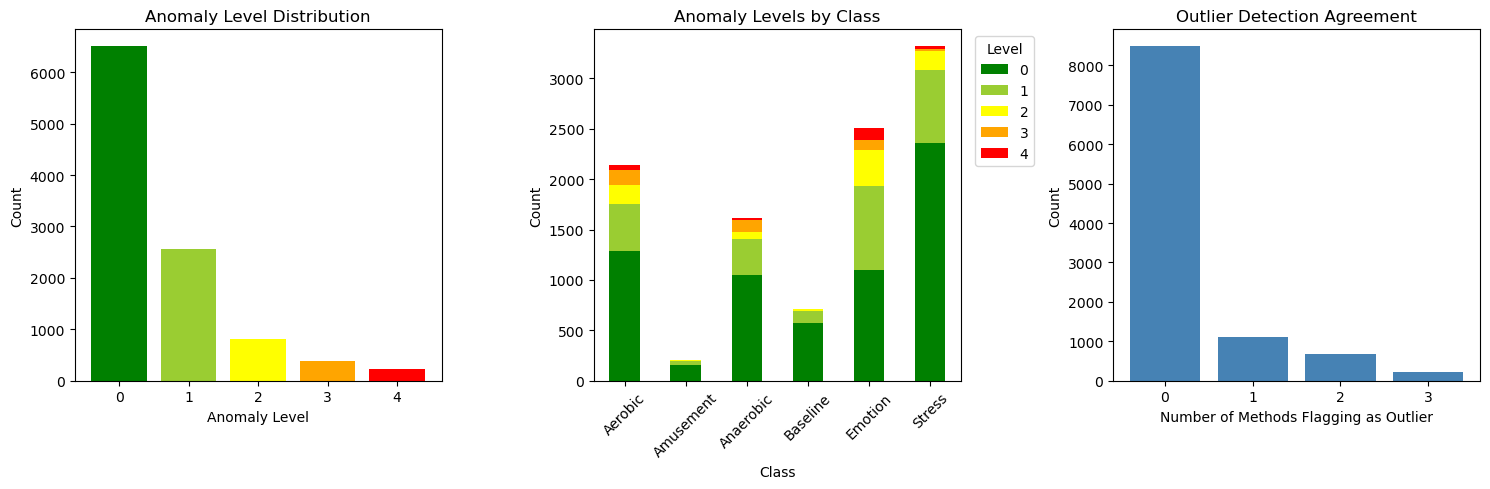

In [15]:
# Visualize anomaly level distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Level distribution
colors = ['green', 'yellowgreen', 'yellow', 'orange', 'red']
axes[0].bar(level_dist.index, level_dist.values, color=colors)
axes[0].set_xlabel('Anomaly Level')
axes[0].set_ylabel('Count')
axes[0].set_title('Anomaly Level Distribution')
axes[0].set_xticks(range(5))

# Level distribution by class
level_by_class = df.groupby(['label', 'anomaly_level']).size().unstack(fill_value=0)
level_by_class.plot(kind='bar', ax=axes[1], stacked=True, color=colors)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_title('Anomaly Levels by Class')
axes[1].legend(title='Level', bbox_to_anchor=(1.02, 1))
axes[1].tick_params(axis='x', rotation=45)

# Outlier methods agreement
vote_counts = df['outlier_votes'].value_counts().sort_index()
axes[2].bar(vote_counts.index, vote_counts.values, color='steelblue')
axes[2].set_xlabel('Number of Methods Flagging as Outlier')
axes[2].set_ylabel('Count')
axes[2].set_title('Outlier Detection Agreement')
axes[2].set_xticks(range(4))

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'anomaly_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

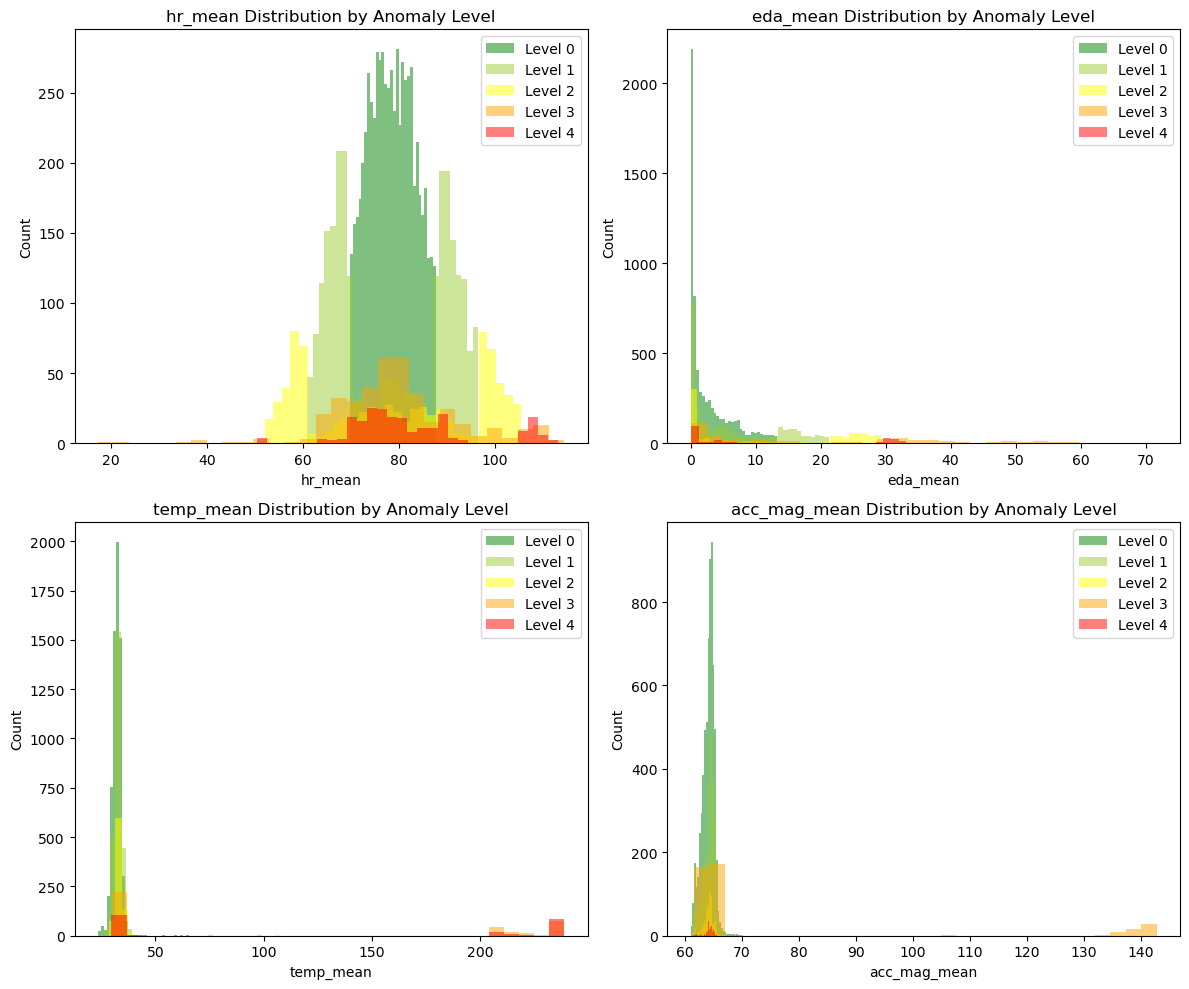

In [16]:
# Visualize signal distributions per anomaly level
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, feat in enumerate(available_features[:4]):
    for level in range(5):
        level_data = df[df['anomaly_level'] == level][feat]
        if len(level_data) > 0:
            axes[idx].hist(level_data, bins=30, alpha=0.5, label=f'Level {level}', color=colors[level])
    axes[idx].set_xlabel(feat)
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f'{feat} Distribution by Anomaly Level')
    axes[idx].legend()

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'anomaly_signal_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Save outlier windows
outlier_windows = df[df['is_outlier'] == 1][['subject_id', 'dataset', 'window_id', 'label', 
                                              'anomaly_level', 'outlier_votes', 'max_zscore'] + available_features]
outlier_windows.to_csv(ANOMALY_PATH / 'outlier_windows.csv', index=False)
print(f"Saved {len(outlier_windows)} outlier windows")

Saved 913 outlier windows


In [18]:
# Save anomaly detection models
joblib.dump(iso_forest, MODELS_PATH / 'isolation_forest.pkl')
joblib.dump(ocsvm, MODELS_PATH / 'one_class_svm.pkl')
print("Saved anomaly detection models")

Saved anomaly detection models


In [19]:
# Final summary
print("="*60)
print("STEP 5 COMPLETE: Anomaly Detection")
print("="*60)
print(f"\nOutlier Detection:")
print(f"  Isolation Forest: {(iso_pred == -1).sum()} outliers")
print(f"  LOF: {(lof_pred == -1).sum()} outliers")
print(f"  One-Class SVM: {(ocsvm_pred == -1).sum()} outliers")
print(f"  Consensus (>=2): {df['is_outlier'].sum()} outliers")
print(f"\nAnomaly Levels:")
for level, count in level_dist.items():
    print(f"  Level {level}: {count} ({count/len(df)*100:.1f}%)")
print(f"\nOutputs saved:")
print(f"  - normal_ranges_per_class.csv")
print(f"  - outlier_detection_comparison.csv")
print(f"  - anomaly_levels.csv")
print(f"  - anomaly_level_distribution.csv")
print(f"  - anomaly_signal_ranges.csv")
print(f"  - anomaly_examples.csv")
print(f"  - outlier_windows.csv")
print("="*60)

STEP 5 COMPLETE: Anomaly Detection

Outlier Detection:
  Isolation Forest: 1051 outliers
  LOF: 1051 outliers
  One-Class SVM: 1058 outliers
  Consensus (>=2): 913 outliers

Anomaly Levels:
  Level 0: 6510 (61.9%)
  Level 1: 2565 (24.4%)
  Level 2: 818 (7.8%)
  Level 3: 392 (3.7%)
  Level 4: 226 (2.2%)

Outputs saved:
  - normal_ranges_per_class.csv
  - outlier_detection_comparison.csv
  - anomaly_levels.csv
  - anomaly_level_distribution.csv
  - anomaly_signal_ranges.csv
  - anomaly_examples.csv
  - outlier_windows.csv
